# **TrainMobileNetV2 On Brain Tumor Classification** 

In this notebook I took MobileNetV2 as another base model. Also handled the grayscale images converted to 3 channel for compatibility. 

Results Summary:
- Accuracy:
  - Started at 73.4% train and 79.0% val
  - Reached 91.5% train and 89.9% val by Epoch 9
- Loss:
  - Train loss dropped from 0.69 to 0.22
  - Val loss dropped from 0.56 to 0.26 (lowest at Epoch 9)
- Best Epoch: Epoch 9 (highest val accuracy, lowest val loss)



---

In [1]:
# imports
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

In [2]:
# data
data_dir = 'tumor_data_cleaned'
train_dir = os.path.join(data_dir, 'Training')
val_dir = os.path.join(data_dir, 'Testing')

# augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
     validation_split=0.2 # 20% of training data for validation
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#  load images 
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=8,
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [3]:
# mobilenetv2 model (expects 3 channel rgb)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze pretrained weights

# adapt model to get grayscale by repeating channel dimension
input_layer = layers.Input(shape=(224, 224, 1)) # grayscale 
x = layers.Concatenate()([input_layer, input_layer, input_layer])  # -> 3 channels
x = base_model(x, training=False)                         
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(4, activation='softmax')(x)   # 4 classes

mobilenet_model = models.Model(input_layer, output_layer)


mobilenet_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
# train model
mobilenet_history = mobilenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)

Epoch 1/10


C:\Users\eliga\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


714/714 ━━━━━━━━━━━━━━━━━━━━ 63s 85ms/step - accuracy: 0.7342 - loss: 0.6909 - val_accuracy: 0.7902 - val_loss: 0.5583
Epoch 2/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 58s 82ms/step - accuracy: 0.8491 - loss: 0.3876 - val_accuracy: 0.8383 - val_loss: 0.4006
Epoch 3/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.8767 - loss: 0.3265 - val_accuracy: 0.8467 - val_loss: 0.3842
Epoch 4/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.8869 - loss: 0.2955 - val_accuracy: 0.8825 - val_loss: 0.3144
Epoch 5/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 62s 87ms/step - accuracy: 0.8910 - loss: 0.2816 - val_accuracy: 0.8101 - val_loss: 0.5649
Epoch 6/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 64s 90ms/step - accuracy: 0.8999 - loss: 0.2841 - val_accuracy: 0.8772 - val_loss: 0.3193
Epoch 7/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 60s 83ms/step - accuracy: 0.9053 - loss: 0.2585 - val_accuracy: 0.8894 - val_loss: 0.3094
Epoch 8/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.8978 - loss: 0.2586 - val_accurac

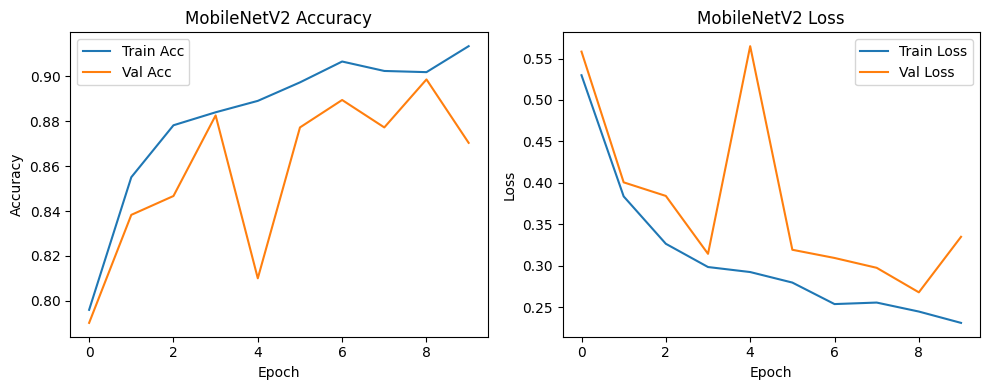

In [7]:
# plot learning curves
plt.figure(figsize=(10, 4))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(mobilenet_history.history['accuracy'], label='Train Acc')
plt.plot(mobilenet_history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(mobilenet_history.history['loss'], label='Train Loss')
plt.plot(mobilenet_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MobileNetV2 Loss')
plt.legend()

plt.tight_layout()
plt.savefig("MobileNetV2_learning_curves.png", dpi=300)
plt.show()

In [8]:
mobilenet_model.save("MobileNetV2_brain_tumor_model.h5")